<a href="https://colab.research.google.com/github/koivunen/beam_damage_detect_dt2/blob/main/damage_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Steel beam damage detector

This is a demo on a steel beam damage detector. It will take in a video and output another video with the damage highlighted. A demo of output can be seen here: https://github.com/koivunen/beam_damage_detect_dt2#demo

## Usage guide (how to use the notebook)

You are in a "notebook" running inside Google Colab, which provides free computational processing for research in the cloud. 
Nothing needs to be installed locally. 
We also provide an input demo video for use if you do not have your own. 

Experiment freely, you can break nothing! You can also always just close the browser tab and start again! You will also [**NOT** incur any cloud costs](https://research.google.com/colaboratory/faq.html) for usage even if you have to login with your google account.

 1. Pre-installation
 
    Before continuing, you should choose a correct runtime type from the page's top menu to speed up processing: Runtime -> Change Runtime Type. Change it to GPU as seen below:
 
  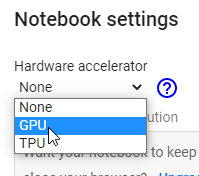
 2. Now we only need to go through the "notebook" following the instructions 
 
    Press the **play buttons** image.png when hovering over each **code cell** below, in numeric order, one after another
 
     - Follow the instructions before each code cell!
    
     - You may also need to check the results for signs of errors. 
    
     - Wait for each cell to finish before proceeding to the next!

**HINT:** There are three "cell" types. First is "text cell", the one you are reading. Another is code cell, which contains program code, which can be executed with the play button. Execution order is important, but you can always start from the beginning by pressing runtime->factory reset runtime. Below each code cell, after execution, is an output cell (after play button) that can contain anything from text to pictures to input dialogs.

## 1. Setting up environment
This code cell will automatically install needed tools and data for the demo. These include Detectron 2 for processing and a detection model for beams from the cloud (automatically downloaded from UTU Seafile).

After pressing play, results text will be printed below the code cell.

In [1]:
!pip install --quiet pyyaml==5.1
!wget --no-clobber -q --show-progress "https://seafile.utu.fi/f/cf91e875424b476cade8/?dl=1" -O weights.pth # beam_damage_detectron2_2022-2-23.pth
import torch
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
NIF="FINISHED INSTALLATION"
restart_runtime=False
try:
  import detectron2
except ImportError as e:
  restart_runtime=True
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'
if restart_runtime:
  print(NIF)
  exit(0)
try:
  import detectron2
except ImportError as e:
  print("FAILED TO INSTALL DETECTRON")
  print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
  print("detectron2:", detectron2.__version__)
  exit(0)
print(NIF)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-hg3vij8s
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-hg3vij8s
  Resolved https://github.com/facebookresearch/detectron2.git to commit 58e472e076a5d861fdcf773d9254a3664e045bf8
  Preparing metadata (setup.py) ... done
  Using cached yacs-0.1.8-py3-none-any.whl (14 kB)
  Using cached fvcore-0.1.5.post20221221.tar.gz (50 kB)
  Preparing metadata (setup.py) ... done
  Using cached iopath-0.1.9-py3-none-any.whl (27 kB)
  Using cached omegaconf-2.3.0-py3-none-any.whl (79 kB)
  Using cached hydra_core-1.3.1-py3-none-any.whl (154 kB)
  Using cached black-22.12.0-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.5 MB)
  Using cached antlr4-python3-runtime-4.9.3.tar.gz (117 kB)
  Preparing metadata (setup.py) ... done
  Using ca

You should see "FINISHED INSTALLATION" above as the last text.

 - If you see popup "**Your session crashed for an unknown reason**" this can be safely ignored and is part of the setup process.
 - If you see "**FAILED TO INSTALL DETECTRON**" or any other error, the setup has likely failed due to Colab updates or other reasons and the demo cannot be run.

## 2. Upload the video with possible steel beam damages
With this cell you can upload a detection video to the system using the dialog that appears when you press the play button. As a demo you can use [this demo video](https://seafile.utu.fi/f/1cbd6551d4fe402b9903/?dl=1) (Note: has not been used in training).

**NOTE:** A video should be low FPS (10fps or lower preferably) and low resolution (320x240 to about 1024x768) for speed.

**Hint**: *You can reuse this notebook by choosing a new file to upload and continuing from the cells below*!

In [2]:
from google.colab import files
uploaded = files.upload()
video_name = next(iter(uploaded.keys()))

Saving detectme.m4v to detectme.m4v


## 3. Setup detection
After the upload, this code cell will set up the detection system. Nothing should break. Just press play as usual.

In [3]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

MetadataCatalog.get("damage_train").set(thing_classes=["damage"])
damage_metadata = MetadataCatalog.get("damage_train")

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7
cfg.DATASETS.TRAIN = ("damage_train",)
cfg.DATASETS.TEST = ("damage_train",)
cfg.TEST.DETECTIONS_PER_IMAGE = 20
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset (default: 512) #TODO: Verify for car+beam
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  
cfg.MODEL.WEIGHTS = 'weights.pth' #cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
predictor = DefaultPredictor(cfg)

[01/31 17:24:37 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from weights.pth ...


## 4. Run detection
This code cell will run the actual detection on the file you uploaded. Detection will take anything from minutes to hours!

**HINT** You can view progress and progress bar below along with predicted time remaining after pressing the play button. The updating preview image shown gets closer and closer to the most confident detection video frame in the video

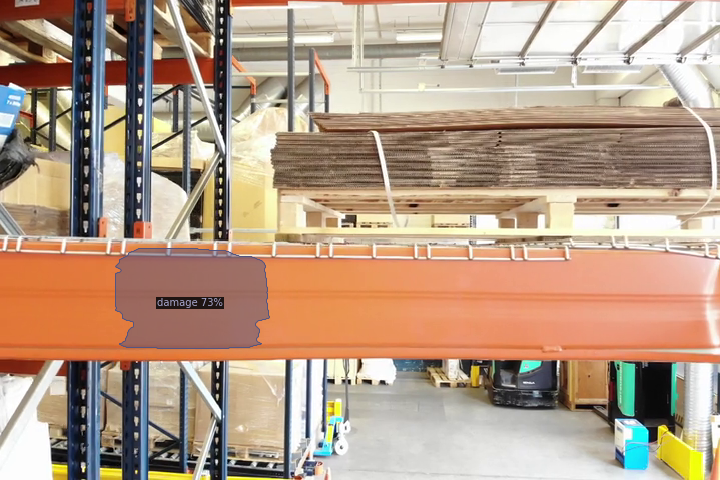

 Damage 76% confidence @ 0:00:14: 100%|██████████| 139/139 [00:32<00:00,  4.26it/s]


In [4]:
import cv2,tqdm,datetime
from time import time as Now
from detectron2.utils.visualizer import ColorMode
from detectron2.utils.video_visualizer import VideoVisualizer
from detectron2.utils.visualizer import ColorMode
from IPython.display import clear_output 

# From https://stackoverflow.com/a/62446532
video = cv2.VideoCapture(video_name)
width = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))
frames_per_second = video.get(cv2.CAP_PROP_FPS)
num_frames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
assert frames_per_second<40,"fps too high, will take forever"
assert num_frames/frames_per_second<60,"video is over a minute long, will take forever"
assert width<1920,"video size is too large, will take forever"
assert height<1080,"video size is too large, will take forever"
print("Video info: w=",width," h=",height," fps=",frames_per_second," frames=",num_frames," seconds=",num_frames/frames_per_second)
max_frames = num_frames
#max_frames = 60
last_show_frame=0

out_filename = video_name+'.detect.mp4'
video_writer = cv2.VideoWriter(out_filename, fourcc=cv2.VideoWriter_fourcc(*"mp4v"), fps=float(frames_per_second), frameSize=(width, height), isColor=True)

v = VideoVisualizer(MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), ColorMode.IMAGE)

def detect(video, maxFrames):
 
    readFrames = 0
    while True:
        hasFrame, frame = video.read()
        if not hasFrame:
            break
        outputs = predictor(frame)
        frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
        data = outputs["instances"].to("cpu")
        visualization = v.draw_instance_predictions(frame, data)
        visualization = cv2.cvtColor(visualization.get_image(), cv2.COLOR_RGB2BGR)
        yield (visualization,data,readFrames)
        readFrames += 1
        if readFrames > maxFrames:
            break

conf_increasing=0

pbar=tqdm.tqdm(detect(video, min(max_frames,num_frames)), total=max_frames)
for visualization,data,fnum in pbar:
#for visualization,outputs,fnum in detect(video, min(max_frames,num_frames)):
    video_writer.write(visualization)
    scores=data.scores.tolist()
    detection=False
    if len(scores)>0:
      conf=round(max(scores)*100)
      if conf_increasing<conf:
        conf_increasing=conf
        detection=True
      #detection=conf>0.5

    if detection and Now()-last_show_frame>8:
      last_show_frame=Now()
      clear_output()
      cv2_imshow(visualization)

    if len(scores)>0:
      conf=round(max(scores)*100)
      s=fnum/frames_per_second
      txt=" Damage "+str(conf)+"% confidence @ "+str(datetime.timedelta(seconds=int(s)))
      pbar.set_description(txt, refresh=True)

video.release()
video_writer.release()
cv2.destroyAllWindows()

## 5. Download results video
Finally, you can download the result video. *(For now, only a video is outputted instead of positional bookmarks)*

In [5]:
from google.colab import files
files.download(out_filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>